# Model5

In [1]:
import os
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load data for train

In [2]:
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')
#buffer datetime
buffer_datetime_train = train.datetime
#remove object
train = train.select_dtypes(exclude=['object'])
#replace misssing value
train.fillna(0,inplace=True)

# Load data for test

In [3]:
test = pd.read_csv('data/test_data/dataset_rev4_test.csv')
#buffer datetime
buffer_datetime_test = test.datetime
#remove object
test = test.select_dtypes(exclude=['object'])
#replace misssing value
test.fillna(0,inplace=True)

In [4]:
print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

dimension of train: (131586, 6)
dimension of test: (16147, 5)


In [5]:
print("features:",list(train.columns))

features: ['I', 'T', 'UV', 'WS', 'RH', 'P']


# Remove outlier

In [6]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# Normalize

In [7]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('P')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('P',axis = 1))
mat_y = np.array(train.P).reshape((118427,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

# Create training_set and prediction_set

In [8]:
# List of features
COLUMNS = col_train #column train (x train)
FEATURES = col_train_bis  #column train-label (x test)
LABEL = "P"

# Columns
feature_cols = FEATURES #(x test)

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS] #column train (x train)
prediction_set = train.P # column P

In [9]:
print(type(training_set))
print(type(prediction_set))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Create x_train and Test 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

In [11]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(79346, 5)
(39081, 5)
(79346,)
(39081,)


# Create training_set

In [13]:
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_sub = training_set[col_train]

# Create testing_set

In [14]:
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

In [15]:
training_set.head(1)

,I,T,UV,WS,RH,P
108496,0.034862,0.452675,0.019608,0.279006,0.619369,0.016393


# Create Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import metrics
from keras import regularizers
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import optimizers

# Model A

In [17]:
def basic_model_A(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    #print(t_model.summary())

    Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    t_model.compile(loss='mean_squared_error',optimizer=Adam,metrics=[metrics.mae])
    return(t_model)

# Model B

In [18]:
def basic_model_B(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    
    Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #print(t_model.summary())
    
    t_model.compile(loss='mean_squared_error',optimizer=Adam,metrics=[metrics.mae])
    return(t_model)

# Model C

In [19]:
def basic_model_C(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

# Model D

In [35]:
def basic_model_D(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="relu", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
       
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    
    t_model.add(Dense(y_size))
       
    t_model.compile(loss='mean_squared_error',optimizer='nadam',metrics=[metrics.mae])
    return(t_model)

# Function Plot

In [23]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

# keras_callbacks

In [27]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

# Train ModelA

In [21]:
model_A = basic_model_A(x_train.shape[1], y_train.shape[1])
model_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs_A = 500
batch_size_A = 128

print('Epochs: ', epochs_A)
print('Batch size: ', batch_size_A)

Epochs:  500
Batch size:  128


In [24]:
history_A = model_A.fit(x_train, y_train,
    batch_size=batch_size_A,
    epochs=epochs_A,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(x_test, y_test),
    callbacks=keras_callbacks)

In [25]:
train_score_A = model_A.evaluate(x_train, y_train, verbose=0)
valid_score_A = model_A.evaluate(x_test, y_test, verbose=0)

print('Train MAE: ', round(train_score_A[1], 4), ', Train Loss: ', round(train_score_A[0], 4)) 
print('Val MAE: ', round(valid_score_A[1], 4), ', Val Loss: ', round(valid_score_A[0], 4))

Train MAE:  0.0344 , Train Loss:  0.0033
Val MAE:  0.0343 , Val Loss:  0.0033


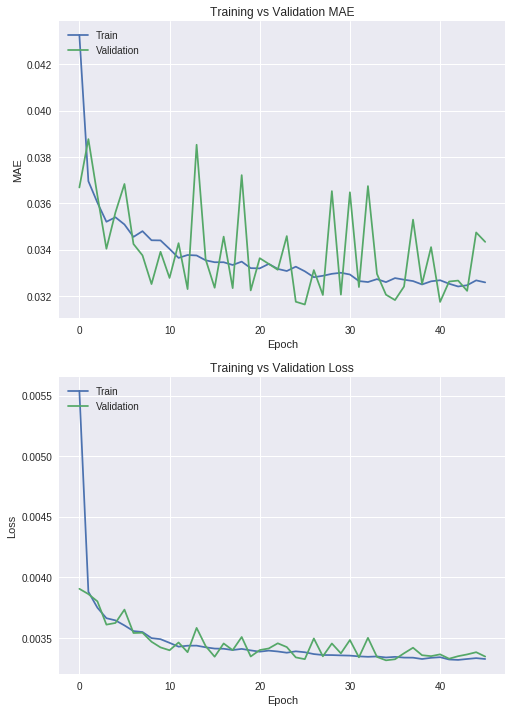

In [27]:
plot_hist(history_A.history, xsize=8, ysize=12)

In [28]:
model_A.predict(x_train)

array([[0.03385469],
       [0.1817658 ],
       [0.07513492],
       ...,
       [0.11534031],
       [0.45420498],
       [0.68105525]], dtype=float32)

# Train ModelB

In [24]:
model_B = basic_model_B(x_train.shape[1], y_train.shape[1])
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 6,691
Trainable params: 6,691
Non-trainable params: 0
_________________________________________________________________


In [25]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


In [28]:
history_B = model_B.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(x_test, y_test),
    callbacks=keras_callbacks)

In [29]:
train_score_B = model_B.evaluate(x_train, y_train, verbose=0)
valid_score_B = model_B.evaluate(x_test, y_test, verbose=0)

print('Train MAE: ', round(train_score_B[1], 4), ', Train Loss: ', round(train_score_B[0], 4)) 
print('Val MAE: ', round(valid_score_B[1], 4), ', Val Loss: ', round(valid_score_B[0], 4))

Train MAE:  0.0304 , Train Loss:  0.0032
Val MAE:  0.0306 , Val Loss:  0.0033


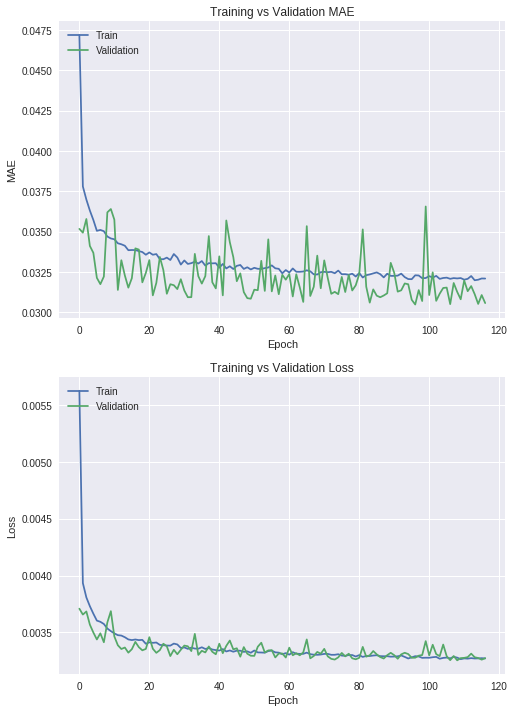

In [30]:
plot_hist(history_B.history, xsize=8, ysize=12)

# Train Model C

In [31]:
model_C = basic_model_C(x_train.shape[1], y_train.shape[1])
model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                480       
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
__________

In [32]:
history_C = model_C.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(x_test, y_test),
    callbacks=keras_callbacks)

In [33]:
train_score_C = model_C.evaluate(x_train, y_train, verbose=0)
valid_score_C = model_C.evaluate(x_test, y_test, verbose=0)

print('Train MAE: ', round(train_score_C[1], 4), ', Train Loss: ', round(train_score_C[0], 4)) 
print('Val MAE: ', round(valid_score_C[1], 4), ', Val Loss: ', round(valid_score_C[0], 4))

Train MAE:  0.1964 , Train Loss:  0.0779
Val MAE:  0.1952 , Val Loss:  0.0773


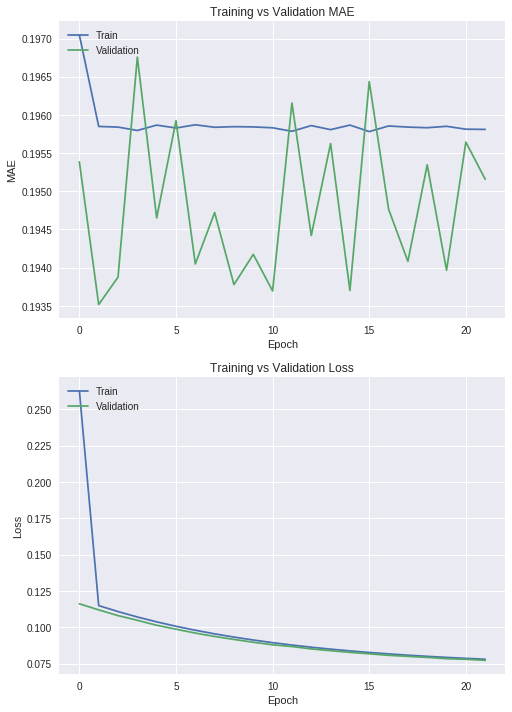

In [34]:
plot_hist(history_C.history, xsize=8, ysize=12)

# Train Model D

In [36]:
model_D = basic_model_D(x_train.shape[1], y_train.shape[1])
model_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 80)                480       
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               8100      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
__________

In [37]:
history_D = model_D.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(x_test, y_test),
    callbacks=keras_callbacks)

In [38]:
train_score_D = model_D.evaluate(x_train, y_train, verbose=0)
valid_score_D = model_D.evaluate(x_test, y_test, verbose=0)

print('Train MAE: ', round(train_score_D[1], 4), ', Train Loss: ', round(train_score_D[0], 4)) 
print('Val MAE: ', round(valid_score_D[1], 4), ', Val Loss: ', round(valid_score_D[0], 4))

Train MAE:  0.1962 , Train Loss:  0.1001
Val MAE:  0.195 , Val Loss:  0.0995


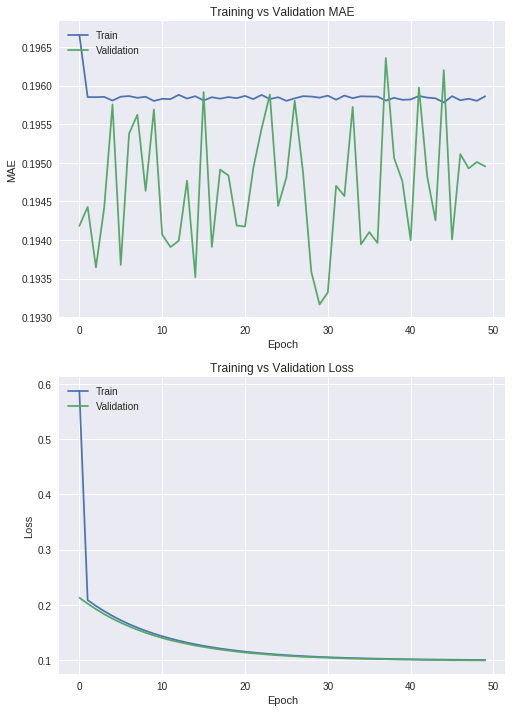

In [39]:
plot_hist(history_D.history, xsize=8, ysize=12)